In [14]:
import os
import sys
import pickle
import numpy as np

# sys.path.append('/n/home04/aboesky/berger/Weird_Galaxies')
sys.path.append('/Users/adamboesky/Research/ay98/Weird_Galaxies')

import matplotlib.pyplot as plt
import matplotlib as mpl

plt.rc('text', usetex=True)
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'cmr10'  # Computer Modern Roman
mpl.rcParams['font.size'] = 12  # Adjust the font size as needed

# Get best model

In [2]:
grid_results = []
# for fname in os.listdir('/n/home04/aboesky/berger/Weird_Galaxies/Paper/hp_abs_mag_grid_search/results'):
for fname in os.listdir('/Users/adamboesky/Research/ay98/Weird_Galaxies/Paper/hp_abs_mag_grid_search/results'):
    with open(f'/Users/adamboesky/Research/ay98/Weird_Galaxies/Paper/hp_abs_mag_grid_search/results/{fname}', 'rb') as f:
    # with open(f'/n/home04/aboesky/berger/Weird_Galaxies/Paper/hp_abs_mag_grid_search/results/{fname}', 'rb') as f:
        grid_results.append(pickle.load(f))

In [14]:
# Get the best loss
best_loss = {'test': np.inf, 'train': np.inf}
best_params = None
for params, loss in grid_results:
    if np.min(loss['test']) < np.min(best_loss['test']):
        best_params = params
        best_loss = loss

print(f'The best parameter combination in our grid search are:\n\nbatch_size, nodes_per_layer, num_linear_output_layers, learning_rate\n{best_params[::-1]}')

The best parameter combination in our grid search are:

batch_size, nodes_per_layer, num_linear_output_layers, learning_rate
[1024, [6, 5, 4, 3], 2, 0.01]


# Plots

## Loss v. Epoch

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_86892/2793020348.py:5: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.yscale('log')


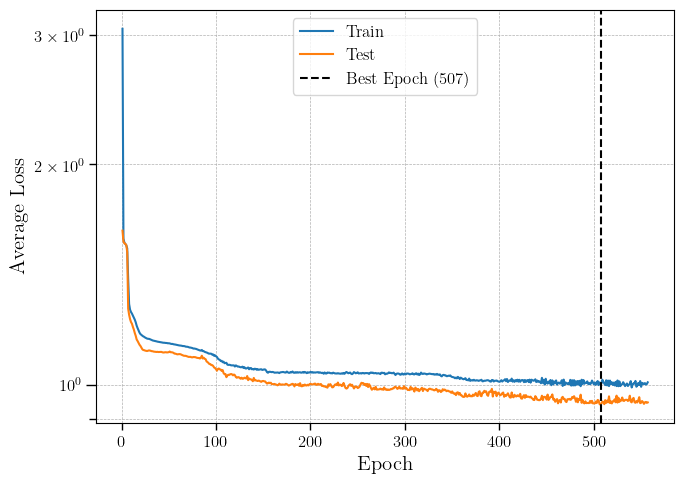

In [15]:
from matplotlib.ticker import LogLocator

plt.figure(figsize=(7, 5))
epochs = np.arange(1, len(best_loss['train']) + 1, 1)
plt.yscale('log')
plt.plot(epochs, best_loss['train'], label='Train')
plt.plot(epochs, best_loss['test'], label='Test')

# Make ticks bigger
plt.tick_params(axis='y', which='major', length=7, width=1)  # Adjust major tick size
plt.tick_params(axis='x', which='major', length=5, width=1)  # Adjust major tick size
plt.tick_params(axis='y', which='minor', length=5, width=1)  # Adjust minor tick size
best_epoch = np.argmin(best_loss['test']) + 1
plt.axvline(x=best_epoch, linestyle='--', color='k', label=f'Best Epoch ({best_epoch})')
plt.grid(True, which="both", ls="--", lw=0.5)

plt.ylabel('Average Loss', fontsize=15)
plt.xlabel('Epoch', fontsize=15)
plt.legend()
plt.tight_layout()
# plt.savefig('/Users/adamboesky/Research/ay98/Weird_Galaxies/Figures/best_loss_v_epoch.png', dpi=1000)
plt.show()

In [5]:
arg_test_min = np.argmin(best_loss['test'])
print(f'Minimum loss values:\n\ttest={best_loss["test"][arg_test_min]}\n\ttrain={best_loss["train"][arg_test_min]}')

Minimum loss values:
	test=0.940676578090738
	train=1.0044436534026866


## Real v. Pred

In [3]:
sys.path.append('/Users/adamboesky/Research/ay98/Weird_Galaxies/Paper')
import torch
import seaborn as sns
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, precision_recall_curve
from neural_net import resume, CustomLoss, get_model, normalize_arr
from host_prop_nn import load_and_preprocess
PATH_TO_CLEAN_DATA = '/Users/adamboesky/Research/ay98/clean_data'

In [4]:
# Get best model based on grid search    [2048, [18, 15, 12, 9, 6, 4], 3, 0.01]
n_epochs = 1000
# nodes_per_layer = [18, 15, 12, 9, 6, 4]
# num_linear_output_layers = 3
# learning_rate = 0.01
# batch_size = 2048


nodes_per_layer = [6, 5, 4, 3]
num_linear_output_layers = 2
learning_rate = 0.01
batch_size = 1024


torch.set_default_dtype(torch.float64)
model = get_model(num_inputs=6, num_outputs=2, nodes_per_layer=nodes_per_layer, num_linear_output_layers=num_linear_output_layers)
loss_fn = CustomLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
resume(model, '/Users/adamboesky/Research/ay98/Weird_Galaxies/host_prop_nn_abs_mag.pkl')
model.eval()

Sequential(
  (input): Linear(in_features=6, out_features=6, bias=True)
  (act_input): ReLU()
  (layer_0): Linear(in_features=6, out_features=5, bias=True)
  (act_0): ReLU()
  (layer_1): Linear(in_features=5, out_features=4, bias=True)
  (act_1): ReLU()
  (layer_2): Linear(in_features=4, out_features=3, bias=True)
  (act_2): ReLU()
  (pre_output0): Linear(in_features=3, out_features=3, bias=True)
  (output): Linear(in_features=3, out_features=2, bias=True)
)

In [5]:
from host_prop_nn import load_and_preprocess
all_cat, all_photo, photo_train, photo_test, cat_train, cat_test, photo_err_train, photo_err_test, cat_err_train, \
    cat_err_test, photo_norm, photo_mean, photo_std, photo_err_norm, cat_norm, cat_mean, cat_std, cat_err_norm = load_and_preprocess()
print(f'Redshift\n\tmean = {cat_mean[2]}\n\tstd = {cat_std[2]}')
photo_train = np.hstack((photo_train, cat_train[:, 2].reshape(-1, 1)))
photo_test = np.hstack((photo_test, cat_test[:, 2].reshape(-1, 1)))
cat_err_train = cat_err_train[:, :2]
cat_err_test = cat_err_test[:, :2]
cat_train = cat_train[:, :2]
cat_test = cat_test[:, :2]
redshift_mean = cat_mean[-1]
redshift_std = cat_std[-1]
cat_mean = cat_mean[:2]
cat_std = cat_std[:2]

2025-04-09 11:17:40,681 - host_prop_nn.py - INFO - Importing photometry data
2025-04-09 11:18:22,089 - host_prop_nn.py - INFO - Fixing the error for 96514 objects
2025-04-09 11:18:22,127 - host_prop_nn.py - INFO - Dropping 2594528 / 2691042 photozs!
2025-04-09 11:18:22,193 - host_prop_nn.py - INFO - Importing photometry data
2025-04-09 11:18:22,246 - host_prop_nn.py - INFO - Photo stats:
 	mean = [14.82211687 15.05355227 14.98872896 15.23683768 15.26239736]
 	std = [0.73430271 0.70560987 0.7404269  0.71824696 0.79342847]
2025-04-09 11:18:22,248 - host_prop_nn.py - INFO - Catalog stats:
 	mean = [ 9.99878348 -0.13575662 -0.3170729 ]
 	std = [0.83429481 1.04090293 0.26033958]
2025-04-09 11:18:22,252 - host_prop_nn.py - INFO - Length = 84672
2025-04-09 11:18:22,321 - host_prop_nn.py - INFO - Length of speczs = 84672


HEEERRRREE [[ 0.68735514 -3.73327686 -2.95426938]
 [-1.68488085 -0.31710368 -3.29128709]
 [ 1.28118105 -1.88014654 -1.59697336]
 ...
 [-0.91752005 -0.17525813 -0.08646464]
 [-3.6916955  -2.32110538 -3.94510607]
 [-0.55604096 -1.49926118 -0.48175502]]
[ 9.99878348 -0.13575662 -0.3170729 ]
Redshift
	mean = -0.3170728954166741
	std = 0.26033958098503646


In [6]:
print(f'Photo mean = {photo_mean}')
print(f'Photo std = {photo_std}')
print(f'Cat mean = {cat_mean}')
print(f'Cat std = {cat_std}')

Photo mean = [14.82211687 15.05355227 14.98872896 15.23683768 15.26239736]
Photo std = [0.73430271 0.70560987 0.7404269  0.71824696 0.79342847]
Cat mean = [ 9.99878348 -0.13575662]
Cat std = [0.83429481 1.04090293]


In [7]:
# Predict attributes for the galaxies that have SNe
gal_props_pred: torch.Tensor = model(torch.from_numpy(photo_test))
gal_props_pred_untrans = gal_props_pred.detach().numpy()

In [11]:
real.shape

(16935, 2)

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_35523/3841863144.py:2: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # Adjust figsize as needed
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_35523/3841863144.py:16: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(heatmap).T, extent=extent, origin='lower', aspect='auto', cmap='Blues')
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_35523/3841863144.py:40: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  cbar_ax = fig.add_axes([0.92, 0.53, 0.02, 0.37])  # Adjust the position and size as needed
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_35523/3841863144.py:41: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  cbar = fig.colorbar(im, cax=cbar_ax, fr

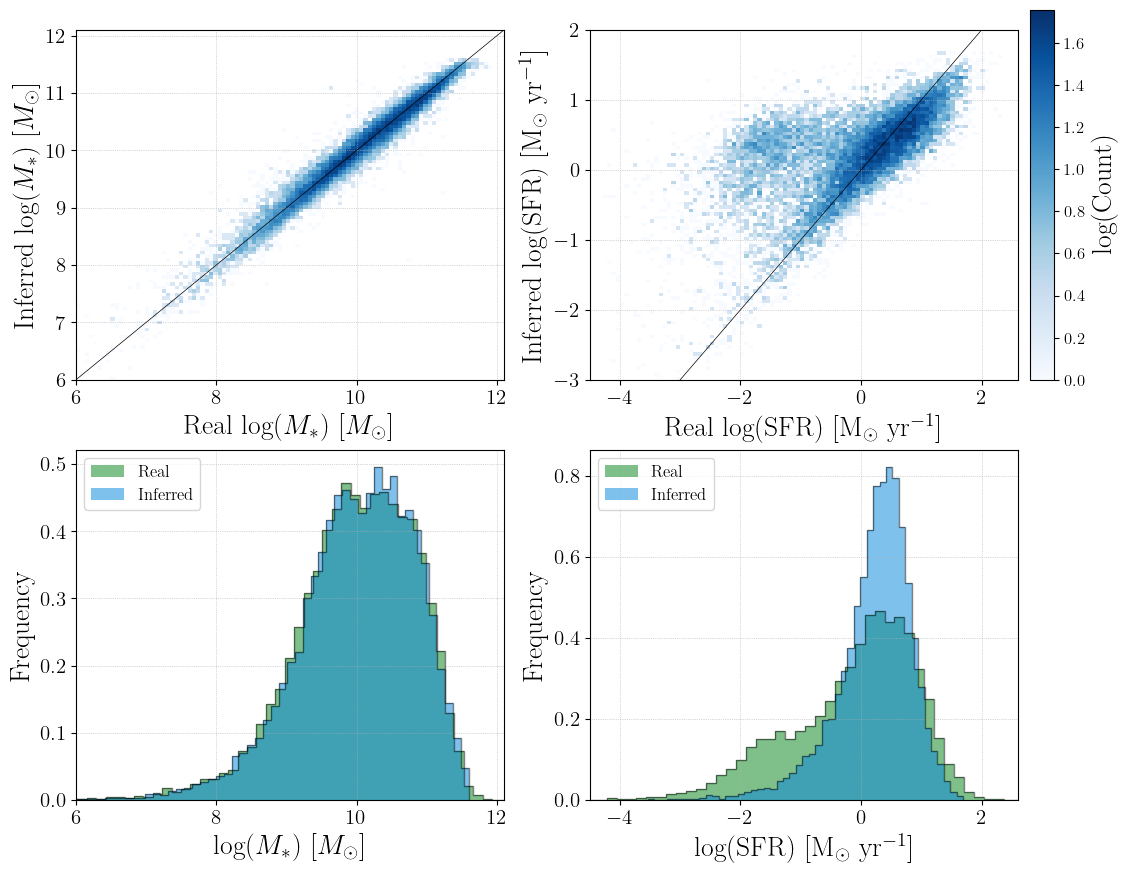

In [10]:
# Real v pred heatmaps
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # Adjust figsize as needed
pred = gal_props_pred_untrans * cat_std + cat_mean
real = cat_test * cat_std + cat_mean
# real[:, 2] = 10**real[:, 2]
# pred[:, 2] = 10**pred[:, 2]
params = [r'$\log(M_*) \ [M_\odot]$', r'$\log(\rm{SFR}) \ [M_\odot \ \rm{yr}^{-1}]$', r'photo-$z$', r'spec-$z$']
xlims = [(6, 12.1), (-4.5, 2.6), (0, 1), (0, 1)]
ylims = [(6, 12.1), (-3, 2), (-0.05, 1), (-0.05, 1)]

for i, (param, xlim, ylim, ax) in enumerate(zip(params, xlims, ylims, axes[0])):
    if i == 3:
        i -= 1
    heatmap, xedges, yedges = np.histogram2d(real[:, i], pred[:, i], bins=(100, 100), range=[xlim, ylim])
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    im = ax.imshow(np.log10(heatmap).T, extent=extent, origin='lower', aspect='auto', cmap='Blues')
    ax.axline((0, 0), slope=1, color='black', linewidth=0.5)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel(fr'Real {param}', fontsize=20)
    ax.set_ylabel(fr'Inferred {param}', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.grid(True, which='both', linestyle=':', linewidth=0.5, zorder=-1)

for i, (param, ax, lim) in enumerate(zip(params, axes[1], xlims)):
    if i == 3:
        i -= 1
    ax.hist(real[:, i], label='Real', alpha=0.5, density=True, bins=50, color='#008114')
    ax.hist(real[:, i], alpha=0.5, density=True, bins=50, color='k', histtype='step')
    ax.hist(pred[:, i], label='Inferred', alpha=0.5, density=True, bins=50, color='#0084DD')
    ax.hist(pred[:, i], alpha=0.5, density=True, bins=50, color='k', histtype='step')
    ax.set_xlabel(param, fontsize=20)
    ax.set_ylabel(r'Frequency', fontsize=20)
    ax.legend(loc='upper left')
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.grid(True, which='both', linestyle=':', linewidth=0.5, zorder=-1)
    ax.set_xlim(lim)

# Add a colorbar
cbar_ax = fig.add_axes([0.92, 0.53, 0.02, 0.37])  # Adjust the position and size as needed
cbar = fig.colorbar(im, cax=cbar_ax, fraction=1.5)
cbar.set_label(r'$\log(\rm{Count})$', fontsize=20)  # Adjust fontsize as needed
plt.subplots_adjust(right=0.91)
# plt.savefig('/Users/adamboesky/Research/ay98/Weird_Galaxies/Final_Paper/Figures/host_prop_real_v_preds.pdf', bbox_inches='tight')
plt.show()

0.15470918216710955


/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_35523/4253889696.py:6: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.scatter(real[:, 0][mask], real[:, 1][mask], label='weird', s=5, alpha=0.5)


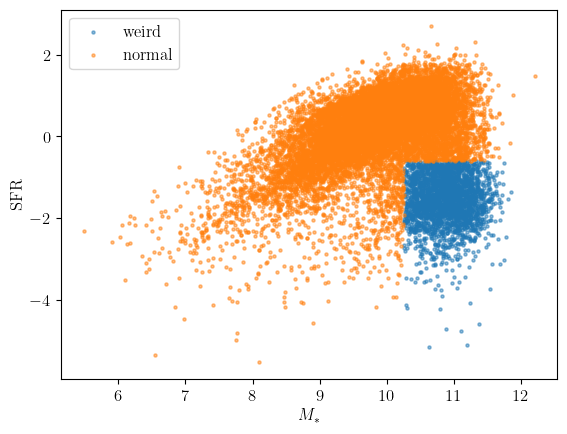

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_35523/4253889696.py:13: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.scatter(real[:, 0], real[:, 1], label='true', s=5, alpha=0.5)


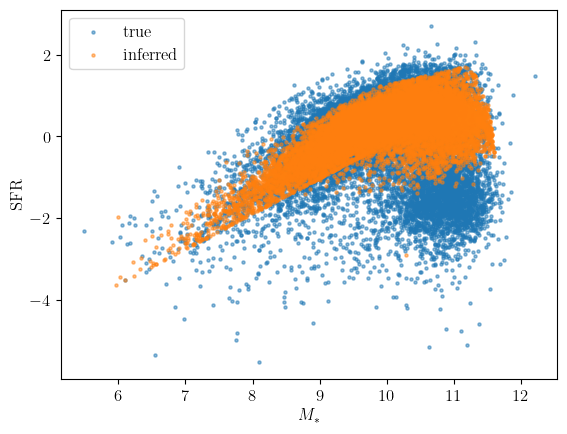

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_35523/4253889696.py:20: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.scatter(real[:, 0], real[:, 1] - real[:, 0], label='true', s=5, alpha=0.5)


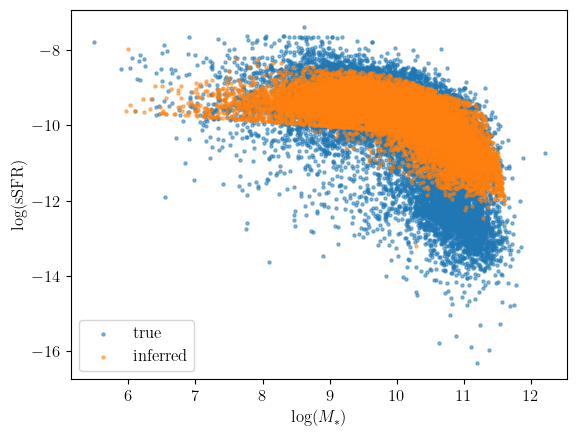

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_35523/4253889696.py:27: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.scatter(redshifts, real[:, 1], label='true', s=5, alpha=0.5)


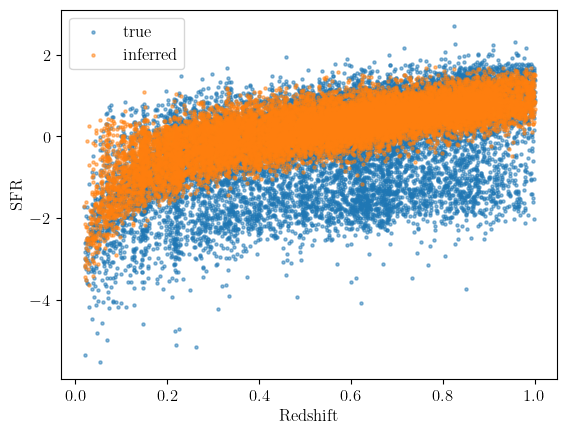

In [12]:
redshifts = photo_test[:, -1] * redshift_std + redshift_mean
redshifts = 10**redshifts
mask = (real[:, 1] < -0.6) & (real[:, 0] > 10.25)
print(np.sum(mask) / len(mask))

plt.scatter(real[:, 0][mask], real[:, 1][mask], label='weird', s=5, alpha=0.5)
plt.scatter(real[:, 0][~mask], real[:, 1][~mask], label='normal', s=5, alpha=0.5)
plt.xlabel(r'$M_*$')
plt.ylabel('SFR')
plt.legend()
plt.show()

plt.scatter(real[:, 0], real[:, 1], label='true', s=5, alpha=0.5)
plt.scatter(pred[:, 0], pred[:, 1], label='inferred', s=5, alpha=0.5)
plt.xlabel(r'$M_*$')
plt.ylabel('SFR')
plt.legend()
plt.show()

plt.scatter(real[:, 0], real[:, 1] - real[:, 0], label='true', s=5, alpha=0.5)
plt.scatter(pred[:, 0], pred[:, 1] - pred[:, 0], label='inferred', s=5, alpha=0.5)
plt.xlabel(r'log($M_*$)')
plt.ylabel('log(sSFR)')
plt.legend()
plt.show()

plt.scatter(redshifts, real[:, 1], label='true', s=5, alpha=0.5)
plt.scatter(redshifts, pred[:, 1], label='inferred', s=5, alpha=0.5)
plt.xlabel(r'Redshift')
plt.ylabel('SFR')
plt.legend()
plt.show()

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_35523/1820828534.py:3: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.hist(r[mask], label='weird sec', density=True, alpha=0.5, bins=50)


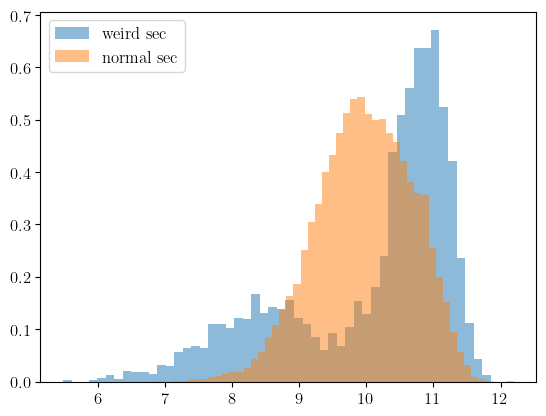

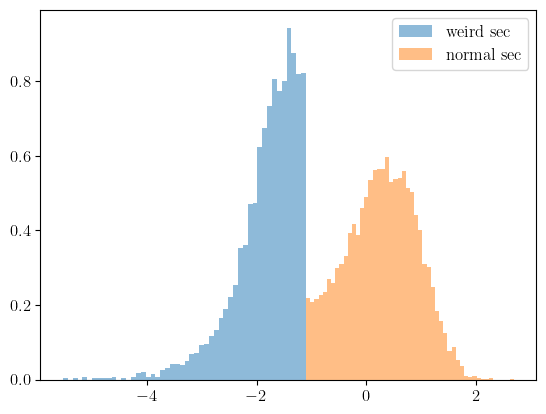

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_35523/1820828534.py:8: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.hist(photo_test[:, -1][mask], label='weird sec', density=True, alpha=0.5, bins=50)


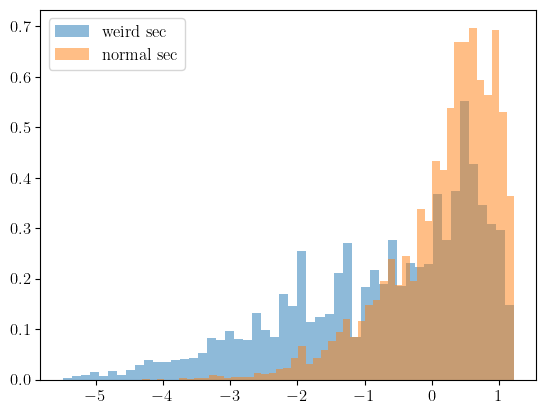

In [15]:
mask = real[:, 1] < -1.1
for r in real.T:
    plt.hist(r[mask], label='weird sec', density=True, alpha=0.5, bins=50)
    plt.hist(r[~mask], label='normal sec', density=True, alpha=0.5, bins=50)
    plt.legend()
    plt.show()

plt.hist(photo_test[:, -1][mask], label='weird sec', density=True, alpha=0.5, bins=50)
plt.hist(photo_test[:, -1][~mask], label='normal sec', density=True, alpha=0.5, bins=50)
plt.legend()
plt.show()

# Fractional Error

In [16]:
# Get the median fractional error
frac_errs = []
errs = []
for i, (r, p) in enumerate(zip(real.T, pred.T)):
    # frac_errs.append(np.abs((r - p) / r))
    frac_errs.append(np.abs((r - p) / np.max((r, p))))
    errs.append(np.abs((r - p)))

errs = np.array(errs)
frac_errs = np.array(frac_errs)

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_35523/332136097.py:4: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.hist(errs[i], bins=50)


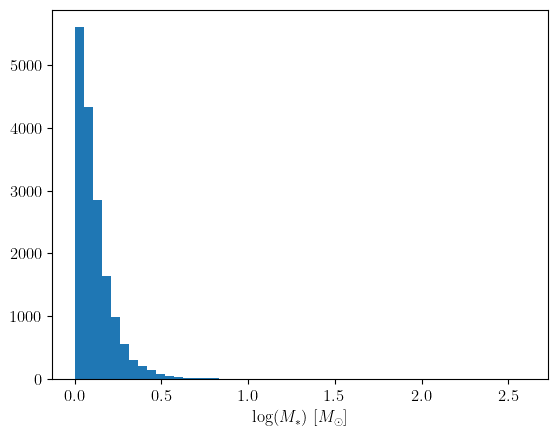

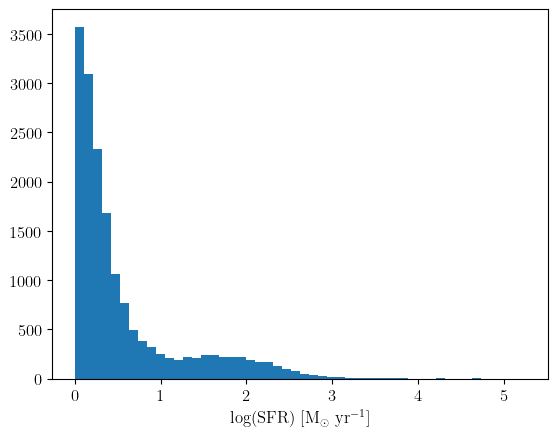

In [17]:
params = [r'$\log(M_*) \ [M_\odot]$', r'$\log(\rm{SFR}) \ [M_\odot \ \rm{yr}^{-1}]$', r'$z$']
xmax = [2, 20]
for i, (param, xm) in enumerate(zip(params, xmax)):
    plt.hist(errs[i], bins=50)
    plt.xlabel(param)
    plt.show()

In [18]:
errs.shape[0]

2

In [ ]:
print(f'Order of results is {params}')
print(f'Fractional Error:\n\tmean = {np.mean(frac_errs, axis=1).round(4)} \n\tmedian = {np.median(frac_errs, axis=1).round(4)} \n\tstdev = {np.std(frac_errs, axis=1).round(4)}\n\n')
print(f'Error:\n\tmean = {np.mean(errs, axis=1).round(4)} \n\tmedian = {np.median(errs, axis=1).round(4)} \n\tstdev = {np.std(errs, axis=1).round(4)}\n\n')

print(f'Measured Uncertainties:\n\tmean = \t{np.mean(cat_err_test, axis=0).round(4)}\n\tmedian = {np.median(cat_err_test, axis=0).round(4)}\n\tstdev = {np.std(cat_err_test, axis=0).round(4)}\n\n')

print(f'Prediction RMSE = {np.sqrt(np.mean(errs**2, axis=1).round(4)).round(4)}')
print(f'Measured uncertainty/true value = {np.mean(np.abs((cat_err_test * cat_std) / (cat_test * cat_std + cat_mean)), axis=0).round(4)}')

Order of results is ['$\\log(M_*) \\ [M_\\odot]$', '$\\log(\\rm{SFR}) \\ [M_\\odot \\ \\rm{yr}^{-1}]$', '$z$']
Fractional Error:
	mean = [0.0096 0.2069] 
	median = [0.0069 0.1076] 
	stdev = [0.01   0.2458]


Error:
	mean = [0.1171 0.5574] 
	median = [0.0847 0.29  ] 
	stdev = [0.1222 0.6622]


Measured Uncertainties:
	mean = 	[0.1419 0.3023]
	median = [0.1359 0.1568]
	stdev = [0.056 0.383]


Prediction RMSE = [0.1694 0.8655]
Measured uncertainty/true value = [0.0121 9.1274]


/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_35523/2452037021.py:2: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.hist(ve, alpha=0.5, density=True, bins=50, label='err')


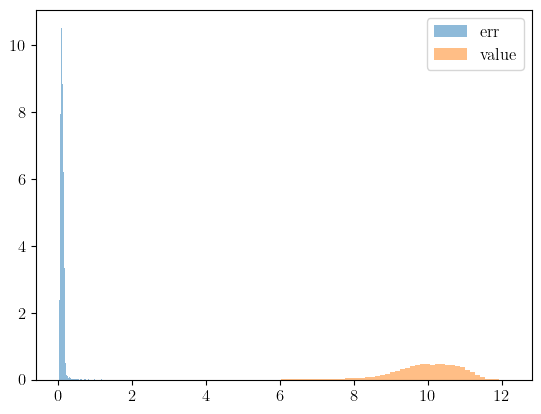

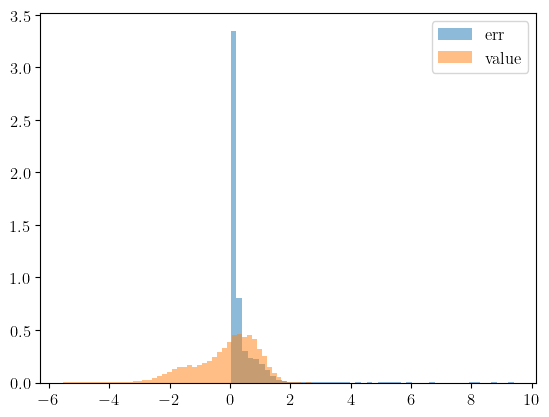

In [22]:
for v, ve in zip((cat_test * cat_std + cat_mean).T, (cat_err_test * cat_std).T):
    plt.hist(ve, alpha=0.5, density=True, bins=50, label='err')
    plt.hist(v, alpha=0.5, density=True, bins=50, label='value')
    plt.legend()
    plt.show()

# Try on the entire SPLASH pipeline

In [92]:
from SPLASH.pipeline import Splash_Pipeline

In [114]:
pipeline = Splash_Pipeline(pre_transformed=True)
pipe_host_props_pred = pipeline.predict_host_properties(photo_test[:, :5], photo_err_test[:, :5])[0]
pipe_host_props_pred2 = pipeline.predict_host_properties(photo_norm_photoz[:, :5], photo_err_norm_photoz[:, :5])[0]
pipe_host_props_pred = np.vstack((pipe_host_props_pred, pipe_host_props_pred2))

/Users/adamboesky/Research/ay98/Weird_Galaxies/SPLASH/pipeline.py:231: RuntimeWarning: overflow encountered in power
  X = 10 ** X
/Users/adamboesky/Research/ay98/Weird_Galaxies/SPLASH/pipeline.py:198: RuntimeWarning: divide by zero encountered in log10
  X = np.log10(X)
/Users/adamboesky/Research/ay98/Weird_Galaxies/SPLASH/pipeline.py:231: RuntimeWarning: overflow encountered in power
  X = 10 ** X
/Users/adamboesky/Research/ay98/Weird_Galaxies/SPLASH/pipeline.py:198: RuntimeWarning: divide by zero encountered in log10
  X = np.log10(X)


/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_34232/3833295922.py:2: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, axes = plt.subplots(2, 4, figsize=(20, 10))  # Adjust figsize as needed
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_34232/3833295922.py:16: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(heatmap).T, extent=extent, origin='lower', aspect='auto', cmap='Blues')
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_34232/3833295922.py:39: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  cbar_ax = fig.add_axes([0.92, 0.53, 0.02, 0.37])  # Adjust the position and size as needed
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_34232/3833295922.py:40: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  cbar = fig.colorbar(im, cax=cbar_ax, fr

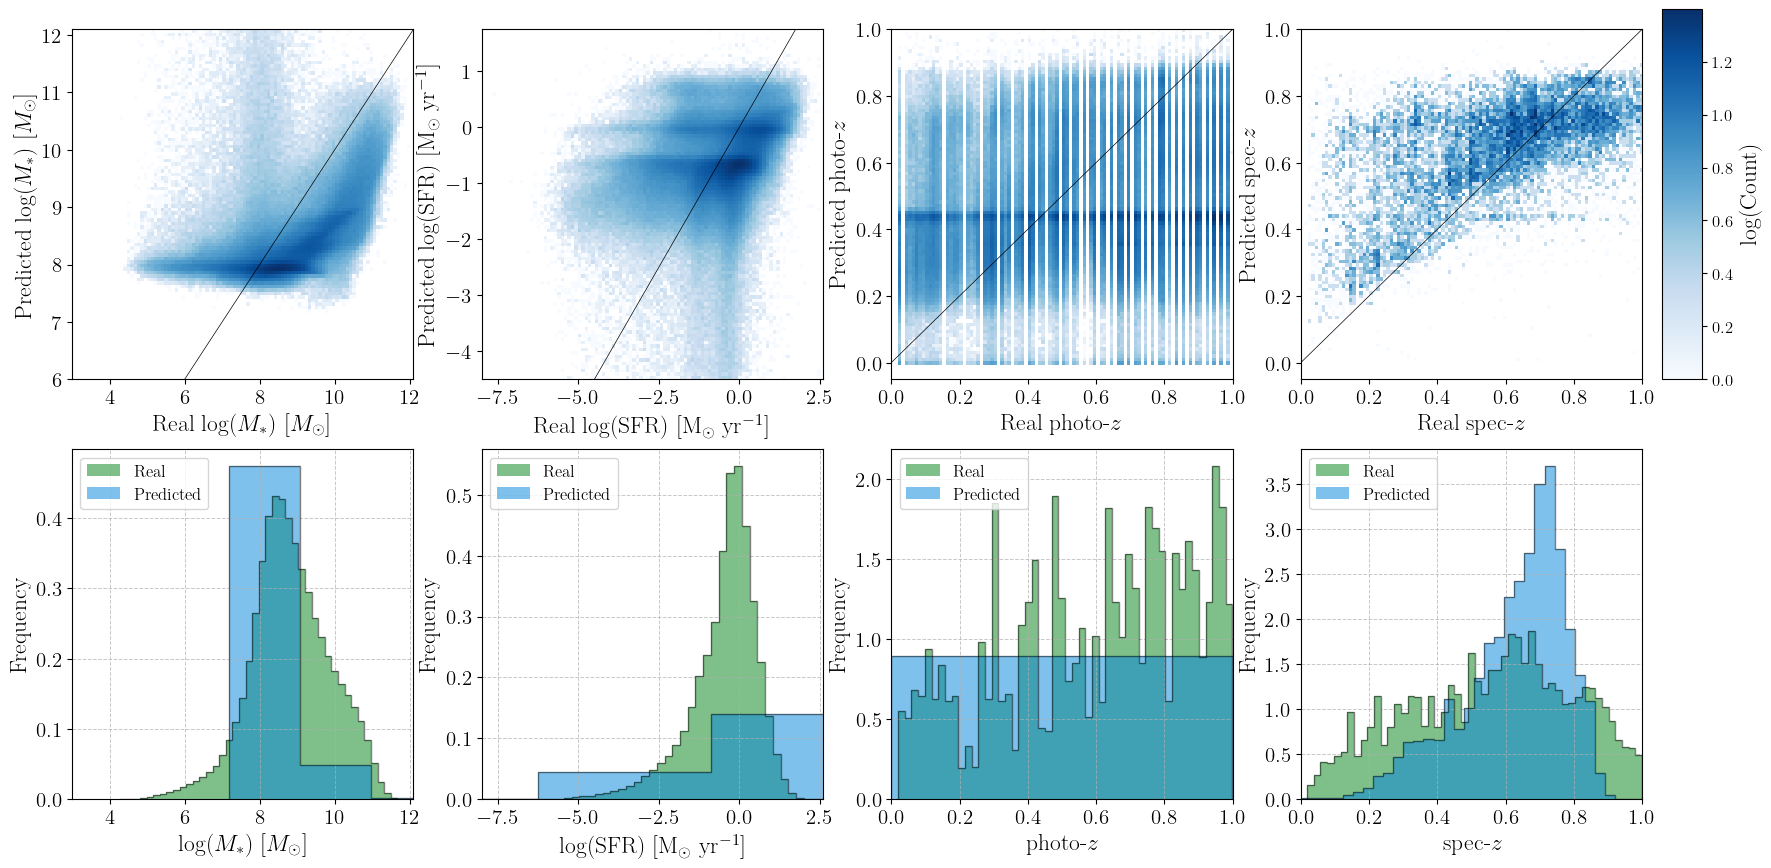

In [117]:
# Real v pred heatmaps
fig, axes = plt.subplots(2, 4, figsize=(20, 10))  # Adjust figsize as needed
pred = pipe_host_props_pred
real = cat_test * cat_std + cat_mean
real[:, 2] = 10**real[:, 2]
params = [r'$\log(M_*) \ [M_\odot]$', r'$\log(\rm{SFR}) \ [M_\odot \ \rm{yr}^{-1}]$', r'photo-$z$', r'spec-$z$']
xlims = [(3, 12.1), (-8, 2.6), (0, 1), (0, 1)]
ylims = [(6, 12.1), (-4.5, 1.75), (-0.05, 1), (-0.05, 1)]
masks = [all_mask, all_mask, photo_z_mask, ~photo_z_mask]

for i, (param, xlim, ylim, ax, mask) in enumerate(zip(params, xlims, ylims, axes[0], masks)):
    if i == 3:
        i -= 1
    heatmap, xedges, yedges = np.histogram2d(real[:, i][mask], pred[:, i][mask], bins=(100, 100), range=[xlim, ylim])
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    im = ax.imshow(np.log10(heatmap).T, extent=extent, origin='lower', aspect='auto', cmap='Blues')
    ax.axline((0, 0), slope=1, color='black', linewidth=0.5)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel(fr'Real {param}', fontsize=17)
    ax.set_ylabel(fr'Predicted {param}', fontsize=17)
    ax.tick_params(axis='both', which='major', labelsize=15)

for i, (param, ax, lim, mask) in enumerate(zip(params, axes[1], xlims, masks)):
    if i == 3:
        i -= 1
    ax.hist(real[:, i][mask], label='Real', alpha=0.5, density=True, bins=50, color='#008114')
    ax.hist(real[:, i][mask], alpha=0.5, density=True, bins=50, color='k', histtype='step')
    ax.hist(pred[:, i][mask], label='Predicted', alpha=0.5, density=True, bins=50, color='#0084DD')
    ax.hist(pred[:, i][mask], alpha=0.5, density=True, bins=50, color='k', histtype='step')
    ax.set_xlabel(param, fontsize=17)
    ax.set_ylabel(r'Frequency', fontsize=17)
    ax.legend(loc='upper left')
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7, zorder=-1)
    ax.set_xlim(lim)

# Add a colorbar
cbar_ax = fig.add_axes([0.92, 0.53, 0.02, 0.37])  # Adjust the position and size as needed
cbar = fig.colorbar(im, cax=cbar_ax, fraction=1.5)
cbar.set_label(r'$\log(\rm{Count})$', fontsize=17)  # Adjust fontsize as needed
plt.subplots_adjust(right=0.91)
# plt.savefig('/Users/adamboesky/Research/ay98/Weird_Galaxies/Figures/host_prop_real_v_preds.pdf', bbox_inches='tight')
plt.show()